In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
cifar10_dataset_folder_path = 'cifar-10-batches-py'
class DLProgress(tqdm):
    last_block = 0
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()     

In [46]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])

        axies[image_i][1].set_xticks([0, 0.25, 0.5, 0.75, 1.0])



Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 65:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


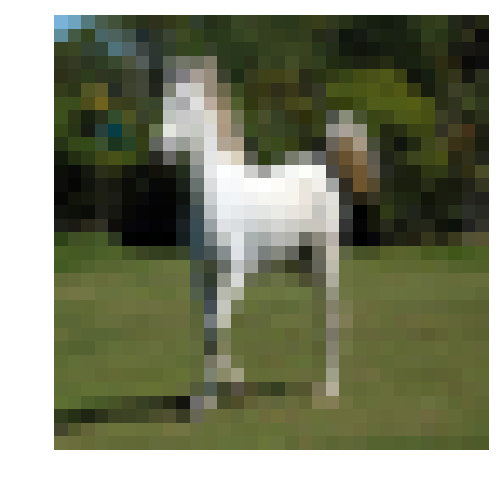

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 4
sample_id = 65
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [4]:
import numpy as np
from sklearn import preprocessing as pp

def normalize(x):
    x = np.array(x)
    x_max = np.max(x)
    x_min = np.min(x)
    output = ( x - x_min )/( x_max - x_min )
    return output

def one_hot_encode(x):
    lb = pp.LabelBinarizer()
    lb.fit(range(10))
    return lb.transform(x)

In [5]:
preprocess_and_save_data(cifar10_dataset_folder_path,normalize,one_hot_encode)
valid_features,valid_labels = pickle.load(open('preprocess_validation.p',mode='rb'))

In [6]:
import tensorflow as tf

# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [7]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [8]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

#Define the fully connected layer that will use the flattened output of the stacked convolution layers to do the actual classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [9]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [13]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built in progress!')

In [14]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

In [15]:
test_conv_net(build_convolution_net)

Neural Network Built in progress!


In [33]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

# Model Hyperparameters
num_epochs = 16
batch_size = 64
keep_probability = 0.45

saver = tf.train.Saver()

print('Training on all Batches from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for batch_ind in range (1,6): 
        for epoch in range(num_epochs):  
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)
    save_path = saver.save(sess, "./model.ckpt")

Training on all Batches from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 253.223846
Valid accuracy: 0.250000
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 126.321800
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 71.566399
Valid accuracy: 0.350000
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 59.870125
Valid accuracy: 0.400000
Epoch number  5, CIFAR-10 Batch Number 1: Valid Loss: 44.534008
Valid accuracy: 0.450000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 28.544230
Valid accuracy: 0.425000
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 18.852579
Valid accuracy: 0.475000
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 15.428520
Valid accuracy: 0.375000
Epoch number  9, CIFAR-10 Batch Number 1: Valid Loss: 10.793483
Valid accuracy: 0.400000
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 6.609648
Valid accuracy: 0.425000
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 4.

In [34]:
import random
test_batch_size = 64
#save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_training.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_path+'.meta') 
        model.restore(sess, save_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Test set accuracy: 0.5005971337579618



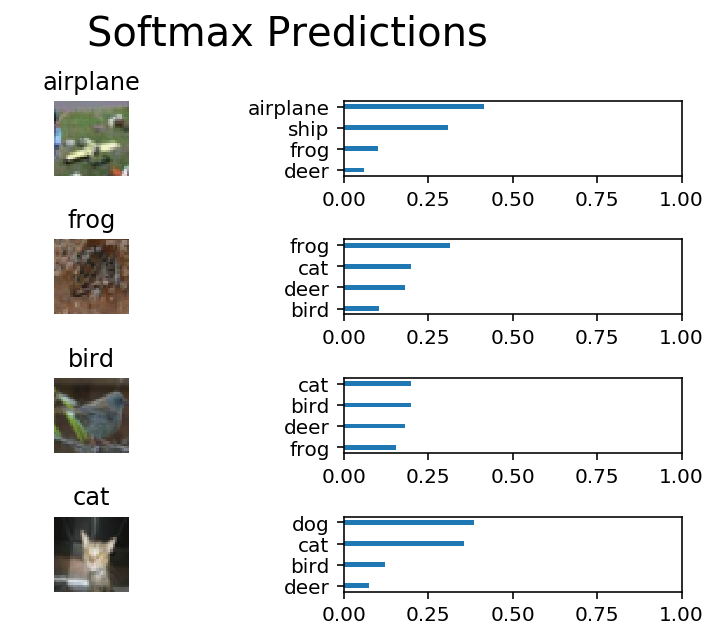

In [48]:
#Calling the Test function
test_classification_model()

#### We need to increase the epochs and batch size to get more accuracy as we can see above that accuracy is 50%. Above it predicted Cat as dog and frog and cat as same.